<a href="https://colab.research.google.com/github/mohammad2682/FVS-SVM-RKHS/blob/main/SVM_RKHS_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn import datasets, svm
import seaborn as sns

In [ ]:
N_m=5

In [ ]:
import sklearn
A, y=sklearn.datasets.make_classification(n_samples=100,n_features=2,n_informative=2,n_redundant=0,weights=[0.8],random_state=5)
display(A)
display(y)


array([[-0.93329265, -1.27122049],
       [-0.76678931,  1.77992147],
       [-1.46243922,  1.0292152 ],
       [-1.58918963, -0.08327511],
       [-0.85366723, -1.34030612],
       [-1.99471959,  0.78569221],
       [ 0.5641469 ,  0.83419775],
       [ 0.33846794, -1.54519884],
       [-1.21399342,  0.48949947],
       [-0.35152381,  1.05604   ],
       [ 1.42192482,  1.30870092],
       [ 1.18748491,  0.9314009 ],
       [-1.4240168 ,  1.07159472],
       [-1.59251151,  0.04851372],
       [ 0.18521994,  1.53870339],
       [-0.60716266, -1.9878526 ],
       [ 1.65055723, -1.19890744],
       [-0.36971684,  1.67597179],
       [-1.77851943,  0.42337798],
       [-0.48167661, -2.04460722],
       [-2.14938099,  1.46161062],
       [ 0.41611519, -0.78549395],
       [-2.74842332,  0.223314  ],
       [-0.66800473, -1.7171794 ],
       [-1.53130793,  1.05736817],
       [-0.22337125,  0.96919875],
       [-1.22108822, -0.44175003],
       [-2.24822364,  1.51138654],
       [ 0.73445806,

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
def sigma(A):
    N = A.shape[0]
    sigma = []
    for i in range(N):
        for j in range(i+1, N):
            sigma.append(np.square(np.linalg.norm(A[i,:]-A[j,:])))

    return 0.1 * np.max(sigma)

In [ ]:
sig=sigma(A)
print(sig)

4.233840225882515


In [ ]:
def K(FV1, FV2):
    dist = np.linalg.norm(FV1-FV2)
    return np.exp(-1*np.square(dist)/(2*sig))

In [ ]:
def give_KSS(S):
    KSS = []
    for i in S:
        for j in S:
            KSS.append( K(A[i,:], A[j,:]))

    return np.array(KSS).reshape((len(S), len(S)))

In [ ]:
give_KSS([1,5])

array([[1.        , 0.90792768],
       [0.90792768, 1.        ]])

In [ ]:
def give_KSx(S, x):
    KSx = []
    for i in S:
        kx = K(A[i,:], x)
        KSx.append(kx)
    return np.array(KSx).reshape((len(S), 1))

In [ ]:
def give_beta(S, x, sig):
  KSx = give_KSx(S, x)
  KSS = give_KSS(S)
  DSS = np.diag(np.diag(np.sqrt(KSS)))
  beta = np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), DSS)
  return beta

In [ ]:
def give_landa(df, minor_cls, major_cls):
  minor = df.iloc[minor_cls, :]
  major = df.iloc[major_cls, :]
  landa = []
  for col in df.columns[:-1]:
    mean_minor = minor[col].mean()
    mean_major = major[col].mean()
    var_minor = minor[col].var()
    var_major = major[col].var()
    landa_i = np.square(mean_minor - mean_major)/(var_minor - var_major)
    landa.append(landa_i)
  return landa

In [ ]:
def minor_major(df):
  cls = df.iloc[:,-1].unique()
  cls0 = df[df.iloc[:,-1]==cls[0]].shape[0]
  cls1 = df[df.iloc[:,-1]==cls[1]].shape[0]
  minor = cls[0]
  major = cls[1]
  if cls0>cls1:
    minor = cls[1]
    major = cls[0]
  return minor, major

In [ ]:
minor_index=np.where(y==1)[0].tolist()
lambdamax=-np.inf
best_iter=-1
total_S=[]
for i in minor_index:
    current_S=[i]
    ctrl=1
    while (len(current_S)<N_m and ctrl==1):
        current_inv =np.linalg.inv(give_KSS(current_S))
        max_LF=-np.inf
        max_LF_index=-1
        remaining=list(set(range(A.shape[0]))-set(current_S))
        #print(remaining)
        for j in remaining:
            KSx=give_KSx(current_S,A[j,:])
            LF =abs(1-((KSx.T).dot(current_inv).dot(KSx)))
            #print(LF)
            if LF> max_LF:
                max_LF=LF
                max_LF_index=j
        if(max_LF<0.001):
            ctrl=0
        else:
            current_S.append(max_LF_index)
    total_S.append(current_S)  
    

In [25]:
major_index = list(set(range(A.shape[0]))-set(minor_index))
for current_S in total_S:
  flag = 0
  for vector in A:
    beta = give_beta(current_S, vector, sig = sig)
    if flag == 0:
      B = beta
      flag = -1
      continue
    B = np.concatenate((B, beta))

  B_df = pd.DataFrame(B)
  B_df["Class"] = y

  landa = give_landa(B_df, minor_index, major_index)
  landa_t = np.sum(landa)/len(current_S)

  if landa_t > lambdamax:
    #print(landa_t)
    lambdamax = landa_t
    best_iter = current_S
    best_B = B_df.copy()

In [26]:
model = svm.SVC(C = sig)

In [27]:
model.fit(A[best_iter, :], y[best_iter])

SVC(C=2.4859867613554454)

In [28]:
model.score(A, y)

0.87

In [29]:
df = pd.DataFrame(A)
df["Class"] = y
minor_cls, major_cls = minor_major(df)
cls_types= np.array([major_cls, minor_cls])

In [ ]:
cls_types

array([0, 1])

Text(0.5, 89.87999999999997, 'Predicted')

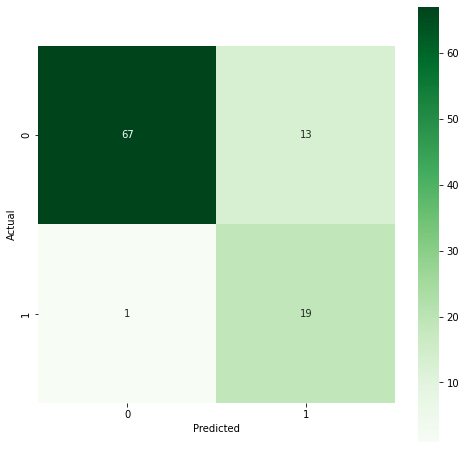

In [ ]:
Y_pred = model.predict(A)
Y_true = y
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=cls_types, yticklabels=cls_types)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

In [ ]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[0][1]
FP = cm[1][0]

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
precision = TP / (TP+FP)

In [ ]:
G_mean = np.sqrt(TPR*TNR)
F_measure = (2*precision*TPR)/(precision+TPR)

print("G-mean for threshold of is: ", G_mean)
print("F-measure for threshold of is: ", F_measure)
print("Precision is: ", precision)

G-mean for threshold of is:  0.764864943864563
F-measure for threshold of is:  0.7307692307692308
Precision is:  0.95
